We draw examples from here:

- https://pythonot.github.io/auto_examples/plot_OT_1D_smooth.html
- https://pythonot.github.io/auto_examples/plot_OT_2D_samples.html
- https://github.com/mblondel/smooth-ot/tree/master/examples/color-transfer

In [ ]:
%matplotlib inline

from google.colab import files

!pip install -q POT
!pip install git+https://github.com/google/jaxopt

import jax.numpy as jnp

import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
from jaxopt import LBFGS
import matplotlib as mpl
# mpl.use('pdf')
import matplotlib.pyplot as plt


     |████████████████████████████████| 664 kB 8.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/jaxopt to /tmp/pip-req-build-lg1zwqor
  Running command git clone -q https://github.com/google/jaxopt /tmp/pip-req-build-lg1zwqor
  Created wheel for jaxopt: filename=jaxopt-0.5-py3-none-any.whl size=129292 sha256=088904e21b28c9851fed657c0bfe4b29b559f4a48726a340d09926fdf7223ab1
  Stored in directory: /tmp/pip-ephem-wheel-cache-x74r83sp/wheels/0c/1a/50/424ccbf29b323d1aa44474c7ccfdd30127d8d6fa97527794d7
Successfully built jaxopt


# Plot setting

In [ ]:
plt.rc('font', family='serif', serif='Times')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


SPINE_COLOR = 'gray'

import numpy as onp
def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax


import matplotlib

def draw_blocks(ax, T):
    # find contiguous chunks between coefficients
    for k, attn_row in enumerate(T):
        brk = onp.diff(attn_row)
        brk = onp.where(brk != 0)[0]
        brk = onp.append(0, brk + 1)
        brk = onp.append(brk, T.shape[0])

        right_border = True
        for s, t in zip(brk[:-1], brk[1:]):
            if attn_row[s:t].sum() == 0:
                right_border = False
                continue
            lines = [(s, k), (t, k), (t, k + 1), (s, k + 1)]
            lines = onp.array(lines, dtype=onp.float) - 0.5
            path = matplotlib.patches.Polygon(lines, facecolor='none', linewidth=1.5,
                                    alpha=1, joinstyle='round',
                                    closed=not right_border,
                                    edgecolor='#999999')
            ax.add_patch(path)
            right_border = True

def draw_border(ax, T):
    lines = [(0, 0), (0, T.shape[0]), (T.shape[1], T.shape[0]), (T.shape[1], 0)]
    lines = onp.array(lines) - 0.5
    path = matplotlib.patches.Polygon(lines, facecolor='none', linewidth=1.5,
                                alpha=1, joinstyle='round',
                                closed=True, edgecolor='#999999')
    ax.add_patch(path)


from matplotlib import gridspec

def plot1D_mat(a, b, M, title=''):
    r""" Plot matrix :math:`\mathbf{M}`  with the source and target 1D distribution

    Creates a subplot with the source distribution :math:`\mathbf{a}` on the left and
    target distribution :math:`\mathbf{b}` on the top. The matrix :math:`\mathbf{M}` is shown in between.


    Parameters
    ----------
    a : ndarray, shape (na,)
        Source distribution
    b : ndarray, shape (nb,)
        Target distribution
    M : ndarray, shape (na, nb)
        Matrix to plot
    """
    na, nb = M.shape

    gs = gridspec.GridSpec(3, 3)

    xa = np.arange(na)
    xb = np.arange(nb)

    ax1 = pl.subplot(gs[0, 1:])
    pl.plot(xb, b, '#fc8d59', label='Target distribution', lw =3)
    pl.yticks(())
    pl.title(title)
    pl.axis('off')

    ax2 = pl.subplot(gs[1:, 0])
    pl.plot(a, xa, '#999999', label='Source distribution', lw =3)
    pl.gca().invert_xaxis()
    pl.gca().invert_yaxis()
    pl.xticks(())
    pl.axis('off')

    ax3 = pl.subplot(gs[1:, 1:], sharex=ax1, sharey=ax2)
    ax3.imshow(M, interpolation='nearest', cmap='Reds', vmin=0)
    ax3.axis("off")
    draw_blocks(ax3, M)
    draw_border(ax3, M)
    # pl.tight_layout()

def plot2D_samples_mat(xs, xt, G, thr=1e-8, **kwargs):
    r""" Plot matrix :math:`\mathbf{G}` in 2D with lines using alpha values

    Plot lines between source and target 2D samples with a color
    proportional to the value of the matrix :math:`\mathbf{G}` between samples.


    Parameters
    ----------
    xs : ndarray, shape (ns,2)
        Source samples positions
    b : ndarray, shape (nt,2)
        Target samples positions
    G : ndarray, shape (na,nb)
        OT matrix
    thr : float, optional
        threshold above which the line is drawn
    **kwargs : dict
        parameters given to the plot functions (default color is black if
        nothing given)
    """

    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    if 'alpha' in kwargs:
        scale = kwargs['alpha']
        del kwargs['alpha']
    else:
        scale = 1

    eps = 0.2
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                alpha =  G[i, j] / mx * scale
                if not np.isclose(alpha,0):
                  alpha = np.minimum(alpha + eps, 1)
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=alpha, **kwargs)



# K-sparse OT

In [ ]:
"""Projection with k-sparse constraints."""
from typing import Callable, Any
import jax
import jax.numpy as jnp
import jaxopt
from jaxopt._src.projection import projection_sparse_simplex, projection_transport, _make_semi_dual #, _regularized_transport_semi_dual



def _max_l2_top_k(x, k, marginal_b=1.0, gamma=1.0):
  scale = gamma * marginal_b
  p = jaxopt.projection.projection_sparse_simplex(x / scale, k)
  p = jax.lax.stop_gradient(p)
  z = jnp.dot(p, x) - 0.5 * scale * jnp.dot(p, p)
  return z

_max_l2_top_k_grad = jax.grad(_max_l2_top_k)


def _regularized_transport_semi_dual(cost_matrix,
                           marginals_a,
                           marginals_b,
                           make_solver,
                           max_vmap,
                           max_grad_vmap,
                           gamma=1.0):

  r"""Regularized transport in the semi-dual formulation.

  Args:
    cost_matrix: The cost matrix of size (m, n).
    marginals_a: The marginals of size (m,)
    marginals_b: The marginals of size (n,)
    make_solver: A function that makes the optimization algorithm
    max_vmap:  A function that computes the regularized max on columns of
      its matrix-valued input
    max_grad_vmap:  A function that computes gradient of regularized max
      on columns of its matrix-valued input
    gamma: A parameter that controls the strength of regularization.

  Returns:
    The optimized plan. See the text under Eqn. (10) of
      https://arxiv.org/abs/1710.06276
  """
  size_a, size_b = cost_matrix.shape

  if len(marginals_a.shape) >= 2:
    raise ValueError("marginals_a should be a vector.")

  if len(marginals_b.shape) >= 2:
    raise ValueError("marginals_b should be a vector.")

  if size_a != marginals_a.shape[0] or size_b != marginals_b.shape[0]:
    raise ValueError("cost_matrix and marginals must have matching shapes.")

  if make_solver is None:
    make_solver = lambda fun: LBFGS(fun=fun, tol=1e-3, maxiter=500,
                                    linesearch="zoom")

  semi_dual = _make_semi_dual(max_vmap, gamma=gamma)
  solver = make_solver(semi_dual)
  alpha_init = jnp.zeros(size_a)

  # Optimal dual potentials.
  alpha = solver.run(alpha_init,
                     cost_matrix=cost_matrix,
                     marginals_a=marginals_a,
                     marginals_b=marginals_b).params

  # Optimal primal transportation plan.
  X = alpha[:, jnp.newaxis] - cost_matrix
  P = max_grad_vmap(X, marginals_b, gamma).T * marginals_b

  return P, alpha


def k_sparse_projection_transport(sim_matrix: jnp.ndarray,
                                  marginals_a: jnp.ndarray,
                                  marginals_b: jnp.ndarray,
                                  k: int,
                                  row_k_sparse: bool = False,
                                  make_solver: Callable[..., Any] = None,
                                  gamma=1.0,
                                  return_alpha=False):
  r"""Projection onto the transportation polytope with k-sparse constraints.

  Args:
    sim_matrix: similarity matrix, shape=(size_a, size_b).
    marginals_a: marginals a, shape=(size_a,).
    marginals_b: marginals b, shape=(size_b,).
    k: number of nonzeros that each row (if row_k_sparse is True) or
    column (if row_k_sparse is False) can have at most.
    row_k_sparse: if True, each row of transportation plan has at most k
      nonzeros; else, each column of transportation plan has at most k
      nonzeros.
    make_solver: a function of the form make_solver(fun),
      for creating an iterative solver to minimize fun.
    gamma: a parameter that controls the strength of squared l2 regularization.
  Returns:
    plan: transportation matrix, shape=(size_a, size_b).
  References:
    Smooth and Sparse Optimal Transport.
    Mathieu Blondel, Vivien Seguy, Antoine Rolet.
    In Proceedings of Artificial Intelligence and Statistics (AISTATS), 2018.
    https://arxiv.org/abs/1710.06276
  """

  def maxop(x, marginal_b, gamma):
    return _max_l2_top_k(x, k=k, marginal_b=marginal_b, gamma=gamma)

  maxop_vmap = jax.vmap(maxop, in_axes=(1, 0, None))
  max_grad_vmap = jax.vmap(jax.grad(maxop), in_axes=(1, 0, None))

  if row_k_sparse:
    # enforce sparsity constraint rowwise:
    marginals_a, marginals_b = marginals_b, marginals_a
    sim_matrix = sim_matrix.T

  plan, alpha = _regularized_transport_semi_dual(cost_matrix=-sim_matrix,  # pylint: disable=protected-access
                                           marginals_a=marginals_a,
                                           marginals_b=marginals_b,
                                           make_solver=make_solver,
                                           max_vmap=maxop_vmap,
                                           max_grad_vmap=max_grad_vmap,
                                           gamma=gamma)
  if row_k_sparse:
    plan = plan.T

  if return_alpha:
    return plan, alpha
  else:
    return plan

## Generate data



In [ ]:
def make_1D_gauss(n, m, s):
    """return a 1D histogram for a gaussian distribution (`n` bins, mean `m` and std `s`)

    Parameters
    ----------
    n : int
        number of bins in the histogram
    m : float
        mean value of the gaussian distribution
    s : float
        standard deviaton of the gaussian distribution

    Returns
    -------
    h : ndarray (`n`,)
        1D histogram for a gaussian distribution
    """
    x = np.arange(n, dtype=np.float64)
    h = np.exp(-(x - m) ** 2 / (2 * s ** 2))
    return h / h.sum()


def make_1d_bi_gauss(n, mean_std_1, mean_std_2, mix_weights =0.5):
    """return a 1D histogram for a gaussian distribution (`n` bins, mean `m` and std `s`)

    Parameters
    ----------
    n : int
        number of bins in the histogram
    m : float
        mean value of the gaussian distribution
    s : float
        standard deviaton of the gaussian distribution

    Returns
    -------
    h : ndarray (`n`,)
        1D histogram for a gaussian distribution
    """
    m1, s1 = mean_std_1
    m2, s2 = mean_std_2

    x = np.arange(n, dtype=np.float64)
    h1 = np.exp(-(x - m1) ** 2 / (2 * s1 ** 2))
    h2 = np.exp(-(x - m2) ** 2 / (2 * s2 ** 2))

    assert (mix_weights <= 1) and (mix_weights >=0)
    h = mix_weights * h1 + (1 - mix_weights) * h2
    return h / h.sum()



def make_2D_samples_gauss(n, m, sigma, random_state=None):
    r"""Return `n` samples drawn from 2D gaussian :math:`\mathcal{N}(m, \sigma)`

    Parameters
    ----------
    n : int
        number of samples to make
    m : ndarray, shape (2,)
        mean value of the gaussian distribution
    sigma : ndarray, shape (2, 2)
        covariance matrix of the gaussian distribution
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : ndarray, shape (`n`, 2)
        n samples drawn from :math:`\mathcal{N}(m, \sigma)`.
    """

    generator = check_random_state(random_state)
    if np.isscalar(sigma):
        sigma = np.array([sigma, ])
    if len(sigma) > 1:
        P = sp.linalg.sqrtm(sigma)
        res = generator.randn(n, 2).dot(P) + m
    else:
        res = generator.randn(n, 2) * np.sqrt(sigma) + m
    return res


def check_random_state(seed):
    r"""Turn `seed` into a np.random.RandomState instance

    Parameters
    ----------
    seed : None | int | instance of RandomState
        If `seed` is None, return the RandomState singleton used by np.random.
        If `seed` is an int, return a new RandomState instance seeded with `seed`.
        If `seed` is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (int, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('{} cannot be used to seed a numpy.random.RandomState'
                     ' instance'.format(seed))


def dist(x1, x2=None, metric='sqeuclidean', p=2, w=None):
    r"""Compute distance between samples in :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`

    .. note:: This function is backend-compatible and will work on arrays
        from all compatible backends.

    Parameters
    ----------

    x1 : array-like, shape (n1,d)
        matrix with `n1` samples of size `d`
    x2 : array-like, shape (n2,d), optional
        matrix with `n2` samples of size `d` (if None then :math:`\mathbf{x_2} = \mathbf{x_1}`)
    metric : str | callable, optional
        'sqeuclidean' or 'euclidean' on all backends. On numpy the function also
        accepts  from the scipy.spatial.distance.cdist function : 'braycurtis',
        'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice',
        'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis',
        'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
        'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    p : float, optional
        p-norm for the Minkowski and the Weighted Minkowski metrics. Default value is 2.
    w : array-like, rank 1
        Weights for the weighted metrics.


    Returns
    -------

    M : array-like, shape (`n1`, `n2`)
        distance matrix computed with given metric

    """
    if x2 is None:
        x2 = x1
    if metric == "sqeuclidean":
        return euclidean_distances(x1, x2, squared=True)
    elif metric == "euclidean":
        return euclidean_distances(x1, x2, squared=False)
    else:
        if not get_backend(x1, x2).__name__ == 'numpy':
            raise NotImplementedError()
        else:
            if metric.endswith("minkowski"):
                return cdist(x1, x2, metric=metric, p=p, w=w)
            return cdist(x1, x2, metric=metric, w=w)

# Synthetic 1D dataset

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
import scipy as sp


In [ ]:
def make_synthetic_1d_bi_gaussian_dataset():
  n = 32 # nb bins

  # Gaussian distributions
  marginals_a = make_1D_gauss(n, m=16, s= 5 )
  marginals_b = make_1d_bi_gauss(n, (8, 5), (24, 5))
  x = np.arange(n, dtype=np.float64)

  # cost matrix
  cost_matrix = dist(x.reshape((n, 1)), x.reshape((n, 1)))
  cost_matrix /= cost_matrix.max()

  dataset = {'marginals_a': marginals_a,
                          'marginals_b': marginals_b,
                          'cost_matrix': cost_matrix}
  return dataset

synthetic_1d_bi_gaussian_dataset = make_synthetic_1d_bi_gaussian_dataset()


def make_synthetic_1d_gaussian_dataset():
  n = 32 # nb bins

  # Gaussian distributions
  marginals_a = gauss(n, m=10, s=4)  # m= mean, s= std
  marginals_b = gauss(n, m=16, s=5)
  x = np.arange(n, dtype=np.float64)

  # cost matrix
  cost_matrix = dist(x.reshape((n, 1)), x.reshape((n, 1)))
  cost_matrix /= cost_matrix.max()

  dataset = {'marginals_a': marginals_a,
             'marginals_b': marginals_b,
             'cost_matrix': cost_matrix}
  return dataset

synthetic_1d_gaussian_dataset = make_synthetic_1d_gaussian_dataset()


# Synthetic 2D dataset

In [ ]:
def make_synthetic_2d_dataset():

  n = 20 # nb samples

  mu_s = np.array([0, 0])
  cov_s = np.array([[1, 0], [0, 1]])

  mu_t = np.array([4, 4])
  # cov_t = np.array([[1, -.8], [-.8, 1]])
  cov_t = np.array([[1, -.8], [-.6, 1]])

  xs = make_2D_samples_gauss(n, mu_s, cov_s)
  xt = make_2D_samples_gauss(n, mu_t, cov_t)

  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  marginals_a = a/a.sum()
  marginals_b = b/b.sum()
  # loss matrix
  cost_matrix = dist(xs, xt)

  dataset = {'xs': xs,
             'xt': xt,
             'marginals_a': marginals_a,
             'marginals_b': marginals_b,
             'cost_matrix': cost_matrix}
  return dataset
synthetic_2d_dataset = make_synthetic_2d_dataset()

## Plot distributions and loss matrix



In [ ]:
save = False

width  = 390 / 72 / 2 #390/6 pt in inches

ot_formulation_to_alg = {'emd': ot.emd,
                         'kl': ot.emd}

# 1D Experiments:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


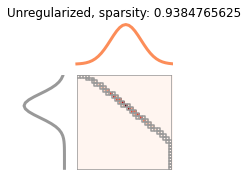

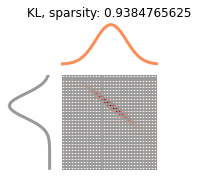

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


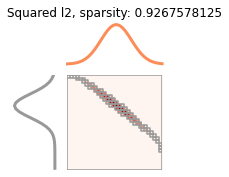

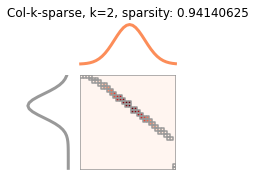

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


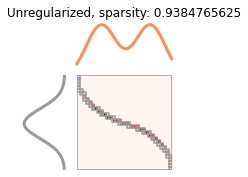

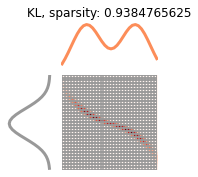

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


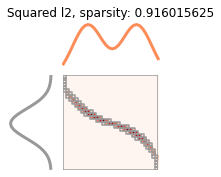

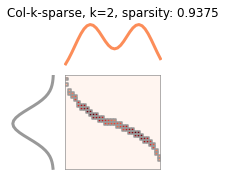

In [ ]:
for dataset in [synthetic_1d_gaussian_dataset, synthetic_1d_bi_gaussian_dataset]:

  a = dataset['marginals_a']
  b = dataset['marginals_b']
  M = dataset['cost_matrix']

  P_unregularized = ot.emd(a, b, M)
  sparsity = 1 - jnp.count_nonzero( P_unregularized )/jnp.size(P_unregularized)

  pl.figure(figsize=(width, width))
  plot1D_mat(a, b, P_unregularized, f'Unregularized, sparsity: {sparsity}')

  if save:
    pl.savefig("emd_1d.pdf", dpi=300, transparent=True)
    files.download("emd_1d.pdf")

  P_kl = ot.smooth.smooth_ot_dual(a, b, M, 2e-3, reg_type='kl')

  pl.figure(figsize=(width, width))
  plot1D_mat(a, b, P_kl, f'KL, sparsity: {sparsity}')
  sparsity = jnp.sum(P_kl == 0)/jnp.size(P_kl)

  if save:
    pl.savefig("kl_plan_1d.pdf", dpi=300, transparent=True)
    files.download("kl_plan_1d.pdf")
  pl.show()


  P_l2 = ot.smooth.smooth_ot_dual(a, b, M, 1e-1, reg_type='l2')
  sparsity = jnp.sum(P_l2 == 0)/jnp.size(P_l2)
  pl.figure(figsize=(width, width))
  plot1D_mat(a, b, P_l2, f'Squared l2, sparsity: {sparsity}')


  P_k2 = k_sparse_projection_transport(sim_matrix=-M,
                                marginals_a=a,
                                marginals_b=b,
                                k=2,
                                row_k_sparse=False)

  sparsity = jnp.sum(P_k2 == 0)/jnp.size(P_k2)
  pl.figure(figsize=(width, width))
  plot1D_mat(a, b, P_k2, f'Col-k-sparse, k=2, sparsity: {sparsity}')

  if save:
    pl.savefig("k_sparse_1d_k2.pdf", dpi=300, transparent=True)
    files.download("k_sparse_1d_k2.pdf")
  pl.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


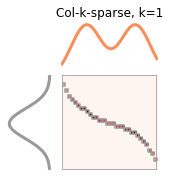

In [ ]:
P_k1, alpha_k1 = k_sparse_projection_transport(sim_matrix=-M,
                              marginals_a=a,
                              marginals_b=b,
                              k=1,
                              make_solver=lambda fun: jaxopt.LBFGS(fun=fun, tol=1e-8, maxiter=1000, linesearch="zoom"),
                              return_alpha=True)

pl.figure(figsize=(width, width))
plot1D_mat(a, b, P_k1, f'Col-k-sparse, k=1')

In [ ]:
k1_plan_reconstruct = get_plan_from_alpha(a, b, -M, alpha_k1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


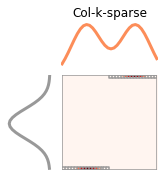

In [ ]:
pl.figure(figsize=(width, width))

plot1D_mat(a, b, k1_plan_reconstruct, f'Col-k-sparse')


In [ ]:

import numpy as onp
import scipy

import jaxopt
import jax.numpy as jnp


def get_plan_from_alpha(a, b, C, alpha, eps=1e-10, method="pinv"):
  beta = onp.min(C - alpha[:, onp.newaxis], axis=0)
  diff = C - alpha[:, onp.newaxis] - beta
  support = (diff <= eps).astype(int)
  rows, cols = onp.nonzero(support)

  ab = onp.concatenate((a, b))
  mn = len(a) + len(b)
  M = onp.zeros((mn, mn))

  for n in range(len(rows)):
    i, j = rows[n], cols[n]
    M[i, n] = 1
    M[j + len(a), n] = 1

  if method == "pinv":
    Minv = scipy.linalg.pinv(M)
    t = onp.dot(Minv, ab)

  elif method == "nnls":
    t = scipy.optimize.nnls(M, ab, maxiter=1000)[0]

  elif method == "pg":
    def fun(x):
      res = jnp.dot(M, x) - ab
      return jnp.dot(res, res)

    projection = jaxopt.projection.projection_simplex
    pg = jaxopt.ProjectedGradient(fun=fun, projection=projection)
    init = jnp.ones(mn) / mn
    t = pg.run(init).params

  else:
    raise ValueError("Unknown method.")

  # Reconstruct the full plan matrix.
  T = onp.zeros((len(a), len(b)))

  for n in range(len(rows)):
    i, j = rows[n], cols[n]
    T[i, j] = t[n]

  return T

In [ ]:
# if __name__ == '__main__':
import ot

# Fake data.
rng = onp.random.RandomState(0)

a = rng.rand(3)
a /= a.sum()

b = rng.rand(4)
b /= b.sum()

C = rng.rand(3, 4)

# Solve the OT problem.
T, dic = ot.emd(a, b, C, log=True)
alpha, beta = dic["u"], dic["v"]

print("POT:")
print(T)

print("Reconstructed:")
print(get_plan_from_alpha(a, b, C, alpha))

POT:
[[0.         0.         0.29399155 0.        ]
 [0.1491009  0.         0.0207687  0.21324712]
 [0.11643422 0.20645751 0.         0.        ]]
Reconstructed:
[[0.         0.         0.29399155 0.        ]
 [0.1491009  0.         0.0207687  0.21324712]
 [0.11643422 0.20645751 0.         0.        ]]


In [ ]:
P_k1, alpha_k1 = k_sparse_projection_transport(sim_matrix=-C,
                              marginals_a=a,
                              marginals_b=b,
                              k=1,
                              make_solver=lambda fun: jaxopt.LBFGS(fun=fun, tol=1e-8, maxiter=500, linesearch="zoom"),
                              return_alpha=True)

In [ ]:
alpha_k1

DeviceArray([235.32108, 235.86029, 235.41591], dtype=float32)

In [ ]:
alpha

array([-0.11998462,  0.4221705 , -0.01959512])

In [ ]:
T, dic = ot.emd(a, b, C, log=True)


# 2D

In [ ]:
a = synthetic_2d_dataset['marginals_a']
b = synthetic_2d_dataset['marginals_b']
M = synthetic_2d_dataset['cost_matrix']
xs = synthetic_2d_dataset['xs']
xt = synthetic_2d_dataset['xt']

plan_sinkhorn = ot.sinkhorn(a, b, M, 1e-1)
plan_l2_reg = ot.smooth.smooth_ot_dual(a, b, M, 10, reg_type='l2', numItermax=500)

plan_emd = ot.emd(a, b, M)



plan_col_2_sparse = k_sparse_projection_transport(sim_matrix=-M,
                              marginals_a=a,
                              marginals_b=b,
                              k=2,
                              make_solver=lambda fun: jaxopt.LBFGS(fun=fun, tol=1e-8, maxiter=500, linesearch="zoom"),
                              row_k_sparse=False)
plan_col_2_sparse = np.asarray(plan_col_2_sparse)


plan_col_1_sparse = k_sparse_projection_transport(sim_matrix=-M,
                              marginals_a=a,
                              marginals_b=b,
                              k=1,
                              make_solver=lambda fun: jaxopt.LBFGS(fun=fun, tol=1e-8, maxiter=500, linesearch="zoom"),
                              row_k_sparse=False)
plan_col_1_sparse = np.asarray(plan_col_1_sparse)




/usr/local/lib/python3.7/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [ ]:
def plot2D_samples_mat(xs, xt, G, thr=1e-8, **kwargs):
    r""" Plot matrix :math:`\mathbf{G}` in 2D with lines using alpha values

    Plot lines between source and target 2D samples with a color
    proportional to the value of the matrix :math:`\mathbf{G}` between samples.


    Parameters
    ----------
    xs : ndarray, shape (ns,2)
        Source samples positions
    b : ndarray, shape (nt,2)
        Target samples positions
    G : ndarray, shape (na,nb)
        OT matrix
    thr : float, optional
        threshold above which the line is drawn
    **kwargs : dict
        parameters given to the plot functions (default color is black if
        nothing given)
    """

    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    if 'alpha' in kwargs:
        scale = kwargs['alpha']
        del kwargs['alpha']
    else:
        scale = 1

    eps = 0.2
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                alpha =  G[i, j] / mx * scale
                if not np.isclose(alpha,0):
                  alpha = np.minimum(alpha + eps, 1)
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=alpha, **kwargs)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

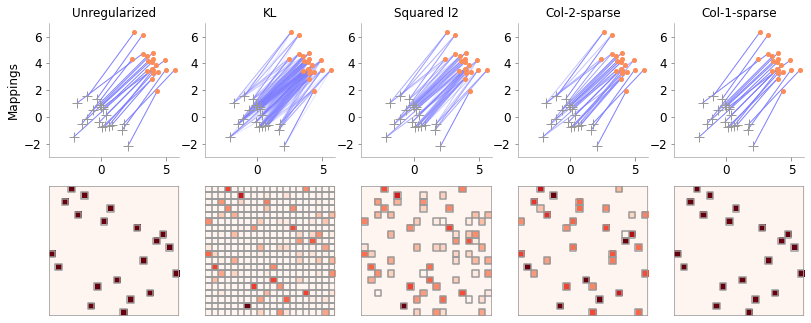

In [ ]:
transp = [plan_emd, plan_sinkhorn, plan_l2_reg, plan_col_2_sparse, plan_col_1_sparse]
title = ["Unregularized", "KL", "Squared l2", "Col-2-sparse", "Col-1-sparse"]

pl.figure(2, figsize=(len(title) * width, 2 * width))


for p in range(len(title)):
    ax1 = pl.subplot(2, len(title), p + 1)
    P = transp[p]

    plot2D_samples_mat(xs, xt, P, color=[.5, .5, 1], alpha=1, linewidth=1, thr=0)

    # ot.plot.plot2D_samples_mat(xs, xt, P, color=[.5, .5, 1], alpha=0.5, linewidth=2, thr=0)
    ax1.plot(xs[:, 0], xs[:, 1], '+', c='#999999', markersize = 10, label='Source samples')
    ax1.plot(xt[:, 0], xt[:, 1], '.', c='#fc8d59', markersize = 8, label='Target samples')
    ax1.set_xlim([-4, 6])
    ax1.set_ylim([-3, 7])
    format_axes(ax1)

    ax1.set_title(title[p])
    # pl.yticks(())
    # pl.xticks(())
    if p < 1:
        ax1.set_ylabel("Mappings")

    ax2 = pl.subplot(2, len(title), p + len(title) + 1)
    ax2.imshow(P, cmap='Reds')
    ax2.axis('off')
    draw_blocks(ax2, P)
    draw_border(ax2, P)

    if p < 1:
        pl.ylabel("Plans")


if save:
  pl.savefig("2d_comparison_5_methods.pdf", dpi=300, transparent=True)
  files.download("2d_comparison_5_methods.pdf")

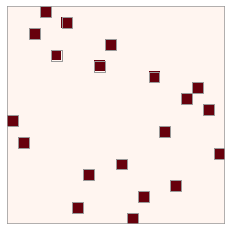

In [ ]:
ax2 = pl.subplot()
ax2.imshow(P, cmap='Reds')
ax2.axis('off')
draw_blocks(ax2, P)
draw_border(ax2, P)